In [ ]:
pip install -U tensorboard_plugin_profile

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from PIL import Image
from pathlib import Path
import subprocess
import shutil
import datetime

from typing import Tuple


import sys  
sys.path.insert(0, '/data')

from loadcbis import get_datasets

ModuleNotFoundError: ignored

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [ ]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
BATCHSIZE = 8

In [13]:
train_dataset, val_dataset, test_dataset = get_datasets(size=896, batches=BATCHSIZE, classification=False)

In [21]:
high_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_gen = high_datagen.flow_from_directory(
    directory='/data/CLAHE Data/Train', 
    #class_mode='binary', 
    class_mode=None,
    color_mode='rgb',
    batch_size=BATCHSIZE,
    target_size=(896, 896),
    interpolation='bicubic',
    subset='training',
    shuffle=True
)
val_gen = high_datagen.flow_from_directory(
    directory='/data/CLAHE Data/Train', 
    #class_mode='binary', 
    class_mode=None,
    color_mode='rgb',
    batch_size=BATCHSIZE,
    target_size=(896, 896),
    interpolation='bicubic',
    subset='validation', 
    shuffle=True
)
test_gen = test_datagen.flow_from_directory(
    directory='/data/CLAHE Data/Test', 
    #class_mode='binary', 
    class_mode=None,
    color_mode='rgb',
    batch_size=BATCHSIZE,
    target_size=(896, 896),
    interpolation='bicubic',
)

Found 972 images belonging to 2 classes.
Found 242 images belonging to 2 classes.
Found 337 images belonging to 2 classes.


In [7]:
def psnr(y_true, y_pred):
    return -10 * K.log(K.mean(K.flatten((y_true - y_pred)) ** 2)) / np.log(10)

def ssim(y_true, y_pred):
  max_val = tf.math.reduce_max([tf.math.reduce_max(y_true), tf.math.reduce_max(y_pred)])
  min_val = tf.math.reduce_min([tf.math.reduce_min(y_true), tf.math.reduce_min(y_pred)])
  return tf.image.ssim(y_true, y_pred, max_val - min_val)

In [ ]:
def srcnn():
    input_tensor = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Resizing(896, 896)(input_tensor)
    x = Conv2D(
            filters=64,
            kernel_size=9,
            activation="swish",
            padding="same"
        )(x)
    x = Conv2D(
            filters=32,
            kernel_size=1,
            activation="swish",
            padding="same"
        )(x)
    outputs = Conv2D(
            filters=3,
            kernel_size=5,
            padding="same"
        )(x)

    model = tf.keras.Model(input_tensor, outputs)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr])
    return model

In [ ]:
model = srcnn()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 896, 896, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 896, 896, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 896, 896, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 896, 896, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
save_checkpoint = ModelCheckpoint(
        'models/srcnn.hdf5',
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="auto",
    )

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True,
    patience=3
)

In [33]:
def train_data_generator(
    train_dataset, original_size, scale
):
  for imgs in train_gen:
    downsize = tf.constant([int(original_size / scale), int(original_size / scale)])
    yield tf.image.resize(images=imgs, size=downsize) / 255.0, imgs / 255.0


In [34]:
def val_data_generator(
    val_dataset, original_size, scale
):
  for imgs in val_gen:
    downsize = tf.constant([int(original_size / scale), int(original_size / scale)])
    yield tf.image.resize(images=imgs, size=downsize) / 255.0, imgs / 255.0

In [24]:
def test_data_generator(
    test_dataset, original_size, scale
):
  for imgs in test_gen:
    downsize = tf.constant([int(original_size / scale), int(original_size / scale)])
    yield tf.image.resize(images=imgs, size=downsize) / 255.0, imgs / 255.0

In [25]:
class DisplayProgress(tf.keras.callbacks.Callback):
  img_x, img_y = next(test_data_generator(test_dataset, 896, scale=4))
  def on_epoch_end(
    self, 
    epoch, 
    logs=None
  ):
    plt.imshow(np.asarray(tf.squeeze(self.model.predict(img_x)[0]*255)), interpolation='nearest')
    plt.show()


In [26]:
model.fit(
        train_data_generator(train_dataset, 896, scale=4),
        validation_data=val_data_generator(val_dataset, 896, scale=4),
        epochs=100,
        batch_size=BATCHSIZE,
        steps_per_epoch=len(train_dataset),
        callbacks=[save_checkpoint, early_stop],
        validation_batch_size=BATCHSIZE,
        validation_steps=len(val_dataset),
    )

NameError: ignored

In [ ]:
model.save(f'/content/drive/MyDrive/SR Basic')

In [ ]:
def fsrcnn():
    input_tensor = tf.keras.Input(shape=(224, 224, 3))
    x = Conv2D(
            filters=56,
            kernel_size=5,
            activation="swish",
            padding="same"
        )(input_tensor)
    x = Conv2D(
            filters=12,
            kernel_size=1,
            activation="swish",
            padding="same"
        )(x)
    x = Conv2D(
            filters=12,
            kernel_size=3,
            activation="swish",
            padding="same"
        )(x)
    x = Conv2D(
            filters=12,
            kernel_size=3,
            activation="swish",
            padding="same"
        )(x)
    x = Conv2D(
            filters=12,
            kernel_size=3,
            activation="swish",
            padding="same"
        )(x)
    x = Conv2D(
            filters=56,
            kernel_size=1,
            activation="swish",
            padding="same"
        )(x)
#    x = tf.keras.layers.ZeroPadding2D(
#        padding=2
#    )(x)
    outputs = Conv2DTranspose(
        filters=3,
        kernel_size=(9,9),
        strides=(4,4),
        padding="same"
    )(x)

    model = tf.keras.Model(input_tensor, outputs)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr])
    return model

In [ ]:
model2 = fsrcnn()

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 56)      4256      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 12)      684       
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 12)      1308      
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 12)      1308      
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 12)      1308      
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 56)      728   

In [27]:
def wdsr(scale=4):
    input_tensor = tf.keras.Input(shape=(224, 224, 3))

    # Main

    m = Conv2D(
            filters=32,
            kernel_size=3,
            padding="same"
        )(input_tensor)

    for _ in range(0, 8):
      m_sub = Conv2D(
          filters=192,
          kernel_size=1,
          padding='same',
          activation='swish'
      )(m)
      m_sub = Conv2D(
          filters=int(32 * 0.8),
          kernel_size=1,
          padding='same'
      )(m_sub)
      m_sub = Conv2D(
          filters=32,
          kernel_size=3,
          padding='same'
      )(m_sub)
      m = tf.keras.layers.Add()([m, m_sub])

    m = Conv2D(
            filters=48,
            kernel_size=3,
            padding="same"
    )(m)

    m = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 4))(m)

    # Skip
    s = Conv2D(
            filters=48,
            kernel_size=5,
            padding="same"
        )(input_tensor)

    s = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 4))(s)

    outputs = tf.keras.layers.add([m, s])

    model = tf.keras.Model(input_tensor, outputs)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr])
    return model
    

In [28]:
model3 = wdsr()

In [29]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 19  6336        ['conv2d[0][0]']                 
                                2)                                                            

In [ ]:
tf.reshape(tf.constant([224, 224]), [-1])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([224, 224], dtype=int32)>

In [ ]:
x, y = next(train_data_generator(train_dataset, original_size=896, scale=4))

In [ ]:
print(tf.shape(x))
print(tf.shape(y))

tf.Tensor([  8 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  8 896 896   3], shape=(4,), dtype=int32)


Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 1.3880e-06 - psnr: 58.9152
Epoch 1: val_loss improved from inf to 0.00000, saving model to models/srcnn.hdf5


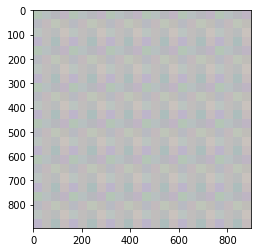

121/121 [==============================] - 251s 2s/step - loss: 1.3880e-06 - psnr: 58.9152 - val_loss: 1.3164e-06 - val_psnr: 58.9173 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 1.2218e-06 - psnr: 59.2641
Epoch 2: val_loss did not improve from 0.00000


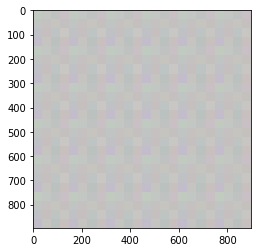

121/121 [==============================] - 243s 2s/step - loss: 1.2218e-06 - psnr: 59.2641 - val_loss: 1.3843e-06 - val_psnr: 58.7045 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.2158e-06 - psnr: 59.2808
Epoch 3: val_loss did not improve from 0.00000


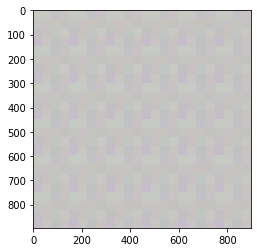

121/121 [==============================] - 244s 2s/step - loss: 1.2158e-06 - psnr: 59.2808 - val_loss: 1.4060e-06 - val_psnr: 58.6384 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - ETA: 0s - loss: 1.2160e-06 - psnr: 59.2782
Epoch 4: val_loss did not improve from 0.00000


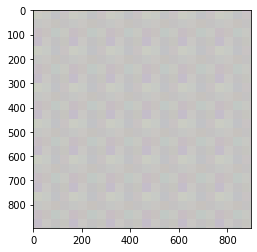

121/121 [==============================] - 243s 2s/step - loss: 1.2160e-06 - psnr: 59.2782 - val_loss: 1.4115e-06 - val_psnr: 58.6219 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - ETA: 0s - loss: 1.1915e-06 - psnr: 59.3703
Epoch 5: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


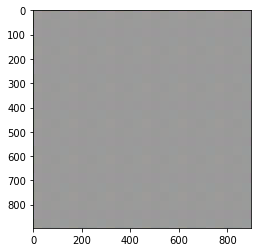

121/121 [==============================] - 244s 2s/step - loss: 1.1915e-06 - psnr: 59.3703 - val_loss: 1.1577e-06 - val_psnr: 59.4304 - lr: 1.0000e-04
Epoch 6/100
121/121 [==============================] - ETA: 0s - loss: 1.1924e-06 - psnr: 59.3593
Epoch 6: val_loss did not improve from 0.00000


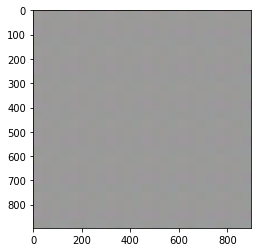

121/121 [==============================] - 243s 2s/step - loss: 1.1924e-06 - psnr: 59.3593 - val_loss: 1.1587e-06 - val_psnr: 59.4264 - lr: 1.0000e-04
Epoch 7/100
121/121 [==============================] - ETA: 0s - loss: 1.1922e-06 - psnr: 59.3603
Epoch 7: val_loss did not improve from 0.00000


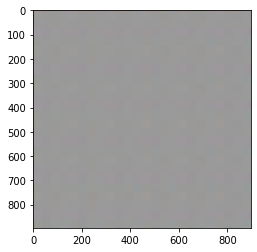

121/121 [==============================] - 245s 2s/step - loss: 1.1922e-06 - psnr: 59.3603 - val_loss: 1.1595e-06 - val_psnr: 59.4230 - lr: 1.0000e-04
Epoch 8/100
121/121 [==============================] - ETA: 0s - loss: 1.1829e-06 - psnr: 59.3966
Epoch 8: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


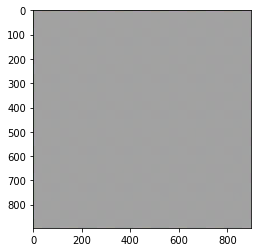

121/121 [==============================] - 244s 2s/step - loss: 1.1829e-06 - psnr: 59.3966 - val_loss: 1.1383e-06 - val_psnr: 59.5121 - lr: 1.0000e-05
Epoch 9/100
121/121 [==============================] - ETA: 0s - loss: 1.1777e-06 - psnr: 59.4203
Epoch 9: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


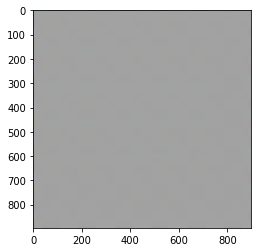

121/121 [==============================] - 244s 2s/step - loss: 1.1777e-06 - psnr: 59.4203 - val_loss: 1.1382e-06 - val_psnr: 59.5123 - lr: 1.0000e-05
Epoch 10/100
121/121 [==============================] - ETA: 0s - loss: 1.1777e-06 - psnr: 59.4205
Epoch 10: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


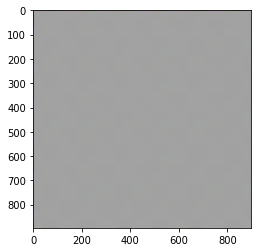

121/121 [==============================] - 242s 2s/step - loss: 1.1777e-06 - psnr: 59.4205 - val_loss: 1.1381e-06 - val_psnr: 59.5127 - lr: 1.0000e-05
Epoch 11/100
121/121 [==============================] - ETA: 0s - loss: 1.1760e-06 - psnr: 59.4214
Epoch 11: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


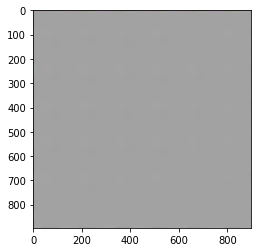

121/121 [==============================] - 242s 2s/step - loss: 1.1760e-06 - psnr: 59.4214 - val_loss: 1.1379e-06 - val_psnr: 59.5144 - lr: 1.0000e-06
Epoch 12/100
121/121 [==============================] - ETA: 0s - loss: 1.1757e-06 - psnr: 59.4241
Epoch 12: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


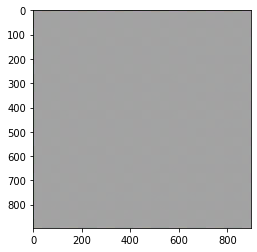

121/121 [==============================] - 247s 2s/step - loss: 1.1757e-06 - psnr: 59.4241 - val_loss: 1.1378e-06 - val_psnr: 59.5151 - lr: 1.0000e-06
Epoch 13/100
121/121 [==============================] - ETA: 0s - loss: 1.1756e-06 - psnr: 59.4256
Epoch 13: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


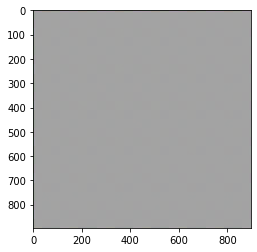

121/121 [==============================] - 246s 2s/step - loss: 1.1756e-06 - psnr: 59.4256 - val_loss: 1.1378e-06 - val_psnr: 59.5155 - lr: 1.0000e-06
Epoch 14/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4260
Epoch 14: val_loss improved from 0.00000 to 0.00000, saving model to models/srcnn.hdf5


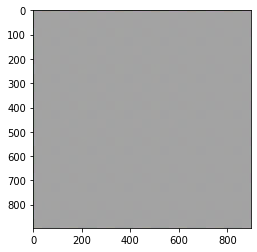

121/121 [==============================] - 247s 2s/step - loss: 1.1753e-06 - psnr: 59.4260 - val_loss: 1.1378e-06 - val_psnr: 59.5155 - lr: 1.0000e-07
Epoch 15/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4261
Epoch 15: val_loss did not improve from 0.00000


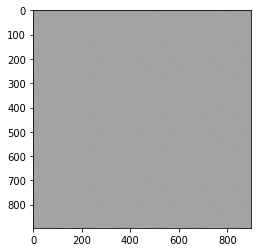

121/121 [==============================] - 244s 2s/step - loss: 1.1753e-06 - psnr: 59.4261 - val_loss: 1.1378e-06 - val_psnr: 59.5155 - lr: 1.0000e-07
Epoch 16/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4263
Epoch 16: val_loss did not improve from 0.00000


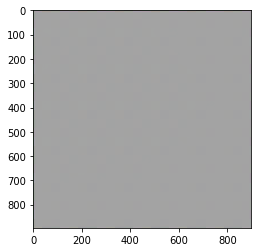

121/121 [==============================] - 243s 2s/step - loss: 1.1753e-06 - psnr: 59.4263 - val_loss: 1.1378e-06 - val_psnr: 59.5156 - lr: 1.0000e-07
Epoch 17/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4263
Epoch 17: val_loss did not improve from 0.00000


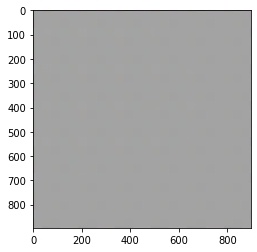

121/121 [==============================] - 243s 2s/step - loss: 1.1753e-06 - psnr: 59.4263 - val_loss: 1.1378e-06 - val_psnr: 59.5156 - lr: 1.0000e-08
Epoch 18/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4263
Epoch 18: val_loss did not improve from 0.00000


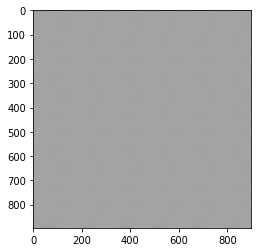

121/121 [==============================] - 266s 2s/step - loss: 1.1753e-06 - psnr: 59.4263 - val_loss: 1.1378e-06 - val_psnr: 59.5156 - lr: 1.0000e-08
Epoch 19/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4263
Epoch 19: val_loss did not improve from 0.00000


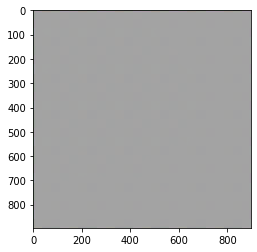

121/121 [==============================] - 240s 2s/step - loss: 1.1753e-06 - psnr: 59.4263 - val_loss: 1.1378e-06 - val_psnr: 59.5156 - lr: 1.0000e-08
Epoch 20/100
121/121 [==============================] - ETA: 0s - loss: 1.1753e-06 - psnr: 59.4263
Epoch 20: val_loss did not improve from 0.00000


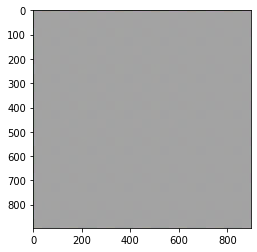

121/121 [==============================] - 242s 2s/step - loss: 1.1753e-06 - psnr: 59.4263 - val_loss: 1.1378e-06 - val_psnr: 59.5156 - lr: 1.0000e-09


In [ ]:
model2.fit(
        train_data_generator(train_dataset, 896, scale=4),
        validation_data=val_data_generator(val_dataset, 896, scale=4),
        epochs=100,
        batch_size=BATCHSIZE,
        steps_per_epoch=len(train_dataset),
        callbacks=get_callbacks(),
        validation_batch_size=BATCHSIZE,
        validation_steps=len(val_dataset),
    )

In [ ]:
model2.save(f'/content/drive/MyDrive/FSRCNN Rough')

In [ ]:
model2.compile(
        optimizer=tf.keras.optimizers.Adam(
          learning_rate=0.0000001,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-07,
        ),
        loss="mean_squared_error",
        metrics=[psnr]
)

Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 1.3268e-06 - psnr: 58.9670

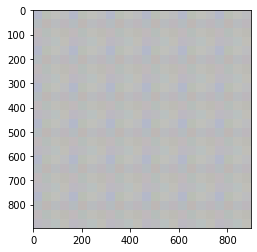

121/121 [==============================] - 249s 2s/step - loss: 1.3268e-06 - psnr: 58.9670 - val_loss: 1.2923e-06 - val_psnr: 58.9965 - lr: 1.0000e-07
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 1.3181e-06 - psnr: 58.9943

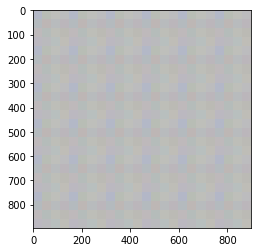

121/121 [==============================] - 242s 2s/step - loss: 1.3181e-06 - psnr: 58.9943 - val_loss: 1.2836e-06 - val_psnr: 59.0250 - lr: 1.0000e-07
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.3099e-06 - psnr: 59.0204

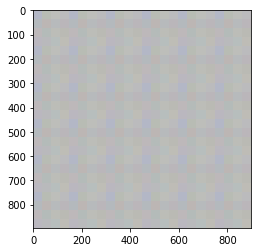

121/121 [==============================] - 242s 2s/step - loss: 1.3099e-06 - psnr: 59.0204 - val_loss: 1.2754e-06 - val_psnr: 59.0522 - lr: 1.0000e-07
Epoch 4/100
121/121 [==============================] - ETA: 0s - loss: 1.3020e-06 - psnr: 59.0453

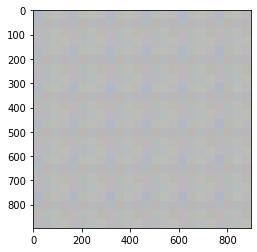

121/121 [==============================] - 244s 2s/step - loss: 1.3020e-06 - psnr: 59.0453 - val_loss: 1.2675e-06 - val_psnr: 59.0783 - lr: 1.0000e-07
Epoch 5/100
121/121 [==============================] - ETA: 0s - loss: 1.2978e-06 - psnr: 59.0583

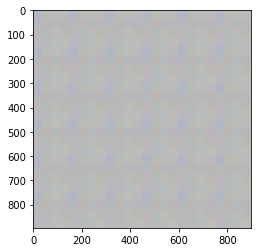

121/121 [==============================] - 242s 2s/step - loss: 1.2978e-06 - psnr: 59.0583 - val_loss: 1.2667e-06 - val_psnr: 59.0809 - lr: 1.0000e-08
Epoch 6/100
121/121 [==============================] - ETA: 0s - loss: 1.2971e-06 - psnr: 59.0606

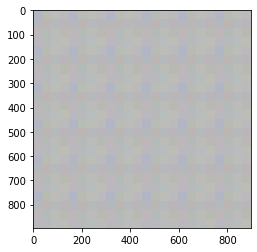

121/121 [==============================] - 241s 2s/step - loss: 1.2971e-06 - psnr: 59.0606 - val_loss: 1.2659e-06 - val_psnr: 59.0834 - lr: 1.0000e-08
Epoch 7/100
121/121 [==============================] - ETA: 0s - loss: 1.2964e-06 - psnr: 59.0630

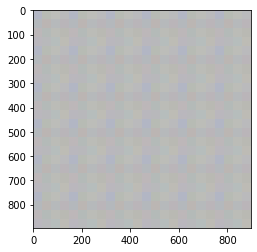

121/121 [==============================] - 241s 2s/step - loss: 1.2964e-06 - psnr: 59.0630 - val_loss: 1.2652e-06 - val_psnr: 59.0860 - lr: 1.0000e-08
Epoch 8/100
121/121 [==============================] - ETA: 0s - loss: 1.2959e-06 - psnr: 59.0643

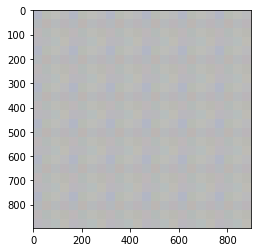

121/121 [==============================] - 241s 2s/step - loss: 1.2959e-06 - psnr: 59.0643 - val_loss: 1.2651e-06 - val_psnr: 59.0862 - lr: 1.0000e-09
Epoch 9/100
121/121 [==============================] - ETA: 0s - loss: 1.2959e-06 - psnr: 59.0645

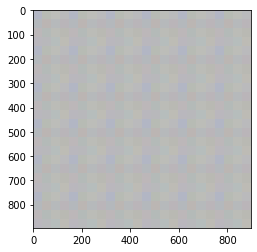

121/121 [==============================] - 240s 2s/step - loss: 1.2959e-06 - psnr: 59.0645 - val_loss: 1.2650e-06 - val_psnr: 59.0865 - lr: 1.0000e-09
Epoch 10/100
121/121 [==============================] - ETA: 0s - loss: 1.2958e-06 - psnr: 59.0648

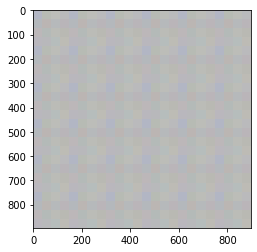

121/121 [==============================] - 240s 2s/step - loss: 1.2958e-06 - psnr: 59.0648 - val_loss: 1.2649e-06 - val_psnr: 59.0867 - lr: 1.0000e-09
Epoch 11/100
121/121 [==============================] - ETA: 0s - loss: 1.2958e-06 - psnr: 59.0649

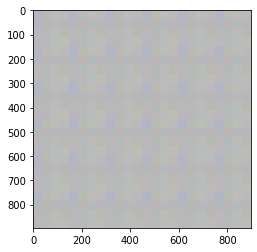

121/121 [==============================] - 242s 2s/step - loss: 1.2958e-06 - psnr: 59.0649 - val_loss: 1.2649e-06 - val_psnr: 59.0867 - lr: 1.0000e-10
Epoch 12/100
121/121 [==============================] - ETA: 0s - loss: 1.2958e-06 - psnr: 59.0649

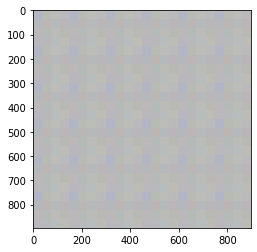

121/121 [==============================] - 243s 2s/step - loss: 1.2958e-06 - psnr: 59.0649 - val_loss: 1.2649e-06 - val_psnr: 59.0867 - lr: 1.0000e-10
Epoch 13/100
116/121 [===========================>..] - ETA: 9s - loss: 1.3076e-06 - psnr: 59.0261 

KeyboardInterrupt: ignored

In [ ]:
model2.fit(
        train_data_generator(train_dataset, 896, scale=4),
        validation_data=val_data_generator(val_dataset, 896, scale=4),
        epochs=100,
        batch_size=BATCHSIZE,
        steps_per_epoch=len(train_dataset),
        callbacks=get_callbacks(),
        validation_batch_size=BATCHSIZE,
        validation_steps=len(val_dataset),
    )

In [ ]:
model2.save(f'/content/drive/MyDrive/FSRCNN Fine')

In [30]:
def get_callbacks(name: str = None):

  save_checkpoint = ModelCheckpoint(
        'models/srcnn.hdf5',
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="auto",
    )

  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
  )

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
  return [save_checkpoint, early_stop, reduce_lr, DisplayProgress()]

In [31]:
model3.compile(
        optimizer=tf.keras.optimizers.Adam(
          learning_rate=0.0000001,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-07,
        ),
        loss="mean_squared_error",
        metrics=[psnr]
)

In [35]:
model3.fit(
        train_data_generator(train_dataset, 896, scale=4),
        validation_data=val_data_generator(val_dataset, 896, scale=4),
        epochs=100,
        batch_size=BATCHSIZE,
        steps_per_epoch=len(train_dataset),
        callbacks=get_callbacks(),
        validation_batch_size=BATCHSIZE,
        validation_steps=len(val_dataset),
    )

Epoch 1/100


ResourceExhaustedError: ignored

In [ ]:
model3.save(f'/content/drive/MyDrive/WDSR Fine')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/WDSR Fine/assets


In [ ]:
srcnn = tf.keras.models.load_model(f'/content/drive/MyDrive/SR Basic', custom_objects = {"psnr": psnr})
srcnn.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr, ssim])

In [ ]:
srcnn.evaluate(
    x = test_data_generator(test_dataset, 896, scale=4),
    batch_size=BATCHSIZE
)

    554/Unknown - 9980s 18s/step - loss: 2.0138e-08 - psnr: 76.9973 - ssim: 0.9600

KeyboardInterrupt: ignored

In [ ]:
fsrcnn = tf.keras.models.load_model(f'/content/drive/MyDrive/FSRCNN Basic', custom_objects = {"psnr": psnr})
fsrcnn.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr, ssim])

In [ ]:
model2 = fsrcnn

In [ ]:
fsrcnn.evaluate(
    x = test_data_generator(test_dataset, 896, scale=4),
    batch_size=BATCHSIZE
)

In [ ]:
img_x, img_y = next(test_data_generator(test_dataset, 896, scale=4))

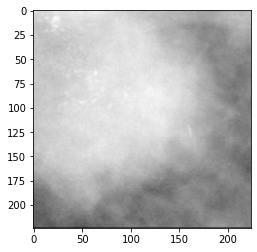

In [ ]:
plt.imshow(np.asarray(tf.squeeze(img_x[0]*255)), interpolation='nearest')
plt.show()

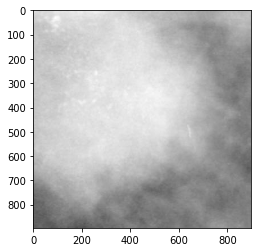

In [ ]:
plt.imshow(np.asarray(tf.squeeze(img_y[0]*255)), interpolation='nearest')
plt.show()

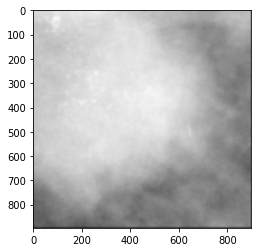

In [ ]:
plt.imshow(np.asarray(tf.squeeze(srcnn.predict(img_x)[0]*255)), interpolation='nearest')
plt.show()

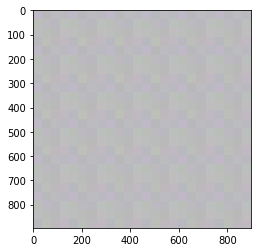

In [ ]:
plt.imshow(np.asarray(tf.squeeze(fsrcnn.predict(img_x)[0]*255)), interpolation='nearest')
plt.show()